In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lstsq

# Volterra nonlinear model
Volterra nonlinear models are commonly used to model the nonlinear behavior of **power amplifiers (PAs)**, which are crucial components in wireless communication systems. Due to their nonlinear nature, PAs introduce distortions in transmitted signals, necessitating **digital predistortion (DPD)** techniques to compensate for these effects.

The Volterra series is an extension of the Taylor series that accounts for memory effects in nonlinear systems.

<div class="alert alert-block alert-info">
<b>Note:</b> Traditional linear models (like FIR filters) cannot capture the nonlinear behavior of the PA. The Volterra series allows us to model both nonlinearities and memory effects.
</div>

 

## Continuous-Time Volterra Series

The Volterra series expansion for a nonlinear system with memory is given by:

$$
y(t) = h_0 + \sum_{n=1}^{\infty} \int_{-\infty}^{\infty} \dots \int_{-\infty}^{\infty} h_n(\tau_1, \tau_2, ..., \tau_n) \prod_{i=1}^{n} x(t - \tau_i) d\tau_i
$$

where:
- $h_0$ is a constant term,
- $h_n(\tau_1, \tau_2, ..., \tau_n$) are the Volterra kernels,
- $x(t)$ is the input signal,
- $y(t)$ is the output signal.

For a truncated Volterra series up to order \( $N$ \):

$$
y(t) = h_0 + \sum_{n=1}^{N} \int_{-\infty}^{\infty} \dots \int_{-\infty}^{\infty} h_n(\tau_1, ..., \tau_n) \prod_{i=1}^{n} x(t - \tau_i) d\tau_i
$$

## Discrete-Time Volterra Model

In discrete-time systems, the Volterra series is written as:

$$
y[k] = h_0 + \sum_{n=1}^{N} \sum_{m_1=0}^{M} \dots \sum_{m_n=0}^{M} h_n(m_1, m_2, ..., m_n) \prod_{i=1}^{n} x[k - m_i]
$$

where:
- $y[k]$ is the discrete-time output,
- $x[k]$ is the discrete-time input,
- $h_n(m_1, m_2, ..., m_n)$ are the discrete Volterra kernels.


## Memory Polynomial Model
A **simplified** form used in PA modeling is the **memory polynomial model**, which is a special case of the Volterra series:

$$
y(t) = \sum_{n=1}^{N} \sum_{m=0}^{M} c_{n,m} x(t - m) {|x(t - m)|}^{n-1}
$$


where:
- $N$ is the **highest nonlinearity order**,
- $M$ is the **memory depth**,
- $c_{n, m}$ are the **complex coefficients** to be estimated.

## Formula for Complex Signal Modeling
If the input signal is **complex-valued**, we can extend the model to:

$$
y(t) = \sum_{n=1}^{N} \sum_{m=0}^{M} c_{n,m} x(t - m) {|x(t - m)|}^{n-1} + \sum_{n=1}^{N} \sum_{m=0}^{M} d_{n,m} x^*(t - m) {|x(t - m)|}^{n-1}
$$

where:
- $x^*(t)$ is the **complex conjugate** $x(t)$,
- The terms involving $x(t)$ capture **nonlinear distortion** effects in power amplifiers..

In [28]:
# Generate a complex-valued input signal (e.g., QAM or OFDM-like)
def generate_complex_signal(N, seed=42):
    np.random.seed(seed)
    real_part = np.random.randn(N)
    imag_part = np.random.randn(N)
    return real_part + 1j * imag_part  # Complex signal


In [67]:
# Memory Polynomial Model Function
def memory_polynomial_model(x, N, M, coeffs):
    """
    Apply the Memory Polynomial Model.
    
    x: Input complex signal
    N: Nonlinearity order
    M: Memory depth
    coeffs: Coefficients of the model
    """
    y = np.zeros_like(x, dtype=complex)
    for n in range(1, N+1):  # Nonlinear order
        for m in range(M):  # Memory taps
            y += coeffs[n-1, m] * np.roll(x, m) * np.abs(np.roll(x, m))**(n-1)
    
    return y


In [68]:
# Least-Squares Estimation of Volterra Model Coefficients
def estimate_volterra_coeffs(x, y, N, M):
    """
    Estimate the Volterra series coefficients using Least Squares.
    
    x: Input signal
    y: Output signal (desired response)
    N: Nonlinearity order
    M: Memory depth
    """
    num_samples = len(x)
    X = np.zeros((num_samples, N*M), dtype=complex)

    # Construct the regression matrix
    for n in range(1, N+1):
        for m in range(M):
            X[:, (n-1)*M + m] = np.roll(x, m) * np.abs(np.roll(x, m))**(n-1)

    # Solve using least squares
    coeffs, _, _, _ = lstsq(X, y)
    
    return coeffs.reshape(N, M)


In [69]:
# Simulation Parameters
N = 2  # Nonlinearity order
M = 5  # Memory depth
num_samples = 1000

In [70]:
# Generate input signal
x = generate_complex_signal(num_samples)

# Define true PA model coefficients (simulated)
true_coeffs = np.random.randn(N, M) + 1j * np.random.randn(N, M)

# Generate output using the true model
y_true = memory_polynomial_model(x, N, M, true_coeffs)

# Estimate the coefficients from the input-output data
estimated_coeffs = estimate_volterra_coeffs(x, y_true, N, M)

# Reconstruct the output using estimated coefficients
y_estimated = memory_polynomial_model(x, N, M, estimated_coeffs)


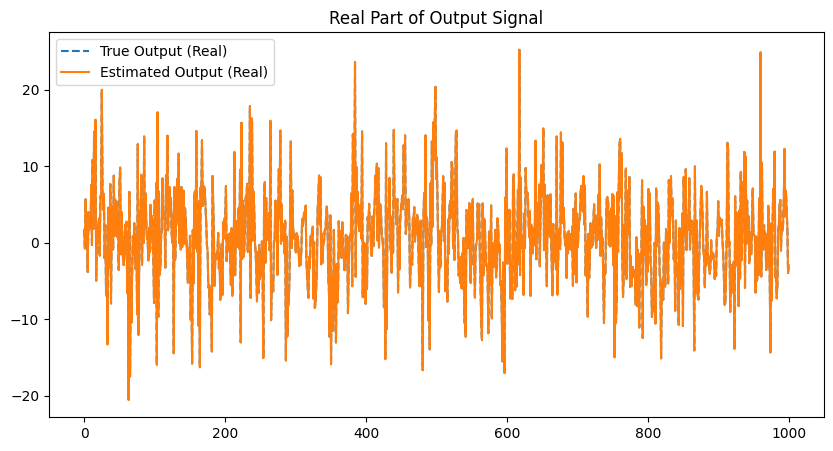

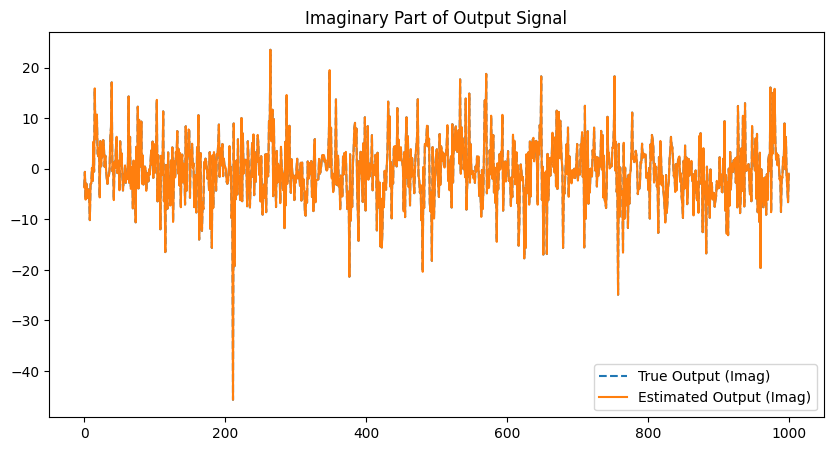

In [71]:
# Plot original vs estimated signal
plt.figure(figsize=(10, 5))
plt.plot(np.real(y_true), label="True Output (Real)", linestyle='dashed')
plt.plot(np.real(y_estimated), label="Estimated Output (Real)", linestyle='solid')
plt.legend()
plt.title("Real Part of Output Signal")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(np.imag(y_true), label="True Output (Imag)", linestyle='dashed')
plt.plot(np.imag(y_estimated), label="Estimated Output (Imag)", linestyle='solid')
plt.legend()
plt.title("Imaginary Part of Output Signal")
plt.show()

In [27]:
# Print results
print("True Coefficients:\n", true_coeffs)
print("\nEstimated Coefficients:\n", estimated_coeffs)

True Coefficients:
 [[-6.75178275e-01-0.19382614j -1.44518671e-01-0.26451484j
  -7.92419921e-01-2.00386236j -3.07961530e-01+0.63541803j
  -1.89361467e+00-1.23925839j]
 [ 2.13293707e-01+0.05993263j  1.20547536e-03+0.27737694j
  -8.17088631e-01+1.3606586j   6.59245668e-01-1.3088204j
   9.37570138e-01-3.01951216j]
 [-1.60755986e+00+0.18384954j -7.62724779e-01+1.80051118j
  -7.69142350e-01+1.23894635j -9.39903101e-01+0.20965942j
   8.29474842e-01-0.49163619j]]

Estimated Coefficients:
 [[-6.75178275e-01-0.19382614j -1.44518671e-01-0.26451484j
  -7.92419921e-01-2.00386236j -3.07961530e-01+0.63541803j
  -1.89361467e+00-1.23925839j]
 [ 2.13293707e-01+0.05993263j  1.20547536e-03+0.27737694j
  -8.17088631e-01+1.3606586j   6.59245668e-01-1.3088204j
   9.37570138e-01-3.01951216j]
 [-1.60755986e+00+0.18384954j -7.62724779e-01+1.80051118j
  -7.69142350e-01+1.23894635j -9.39903101e-01+0.20965942j
   8.29474842e-01-0.49163619j]]
